In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 11})
import matplotlib.dates as mdates
import pandas as pd
# %matplotlib inline

#Dask
# from dask.distributed import Client

# client = Client()
# client

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-93.5)

In [2]:
# Open the parent and child models 
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds_avg = xroms.open_mfnetcdf(path)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)

path1 = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_0000*.nc')
ds_avg_child = xroms.open_mfnetcdf(path1)
ds_avg_child, grid_avg_child = xroms.roms_dataset(ds_avg_child)

#Parent model slices
xislice = slice(271,404)
etaslice = slice(31,149)

#Child model slices
xislice_child = slice(8, 677-8)
etaslice_child = slice(8, 602-8)


In [4]:
ds_avg

<xarray.Dataset>
Dimensions:         (tracer: 5, s_rho: 30, s_w: 31, eta_rho: 191, xi_rho: 671, xi_u: 670, eta_v: 190, ocean_time: 1080)
Coordinates: (12/31)
  * s_rho           (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w             (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lon_u           (eta_rho, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
    lat_u           (eta_rho, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
    ...              ...
    z_rho_v0        (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(30, 190, 671), meta=np.ndarray>
    z_rho_psi0      (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(30, 190, 670), meta=np.ndarray>
    z_w0            (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 191, 671), meta=np.ndarray>
    z_w_u0          (s_w, eta_rho, xi_u) float64 dask.array<chunksize=(31, 191, 670), meta=np.ndarray>
    z_w_v0          (s_w, eta_v, xi_rho) float64 dask.array<chunksize=(31, 190, 671), meta=np.ndarray>
    z_w_psi0        (s_w, eta_v, xi_u) float64 dask.array<chunksize=(31, 190, 670), meta=np.ndarray>
Dimensions without coordinates: tracer
Data variables: (12/165)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    shuffle         int32 ...
    ...              ...
    dV_u            (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 191, 670), meta=np.ndarray>
    dV_w_u          (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 1, 191, 670), meta=np.ndarray>
    dV_v            (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 190, 671), meta=np.ndarray>
    dV_w_v          (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 1, 190, 671), meta=np.ndarray>
    dV_psi          (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 30, 190, 670), meta=np.ndarray>
    dV_w_psi        (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 1, 190, 670), meta=np.ndarray>
Attributes: (12/32)
    file:              ./outputs/2010/NM/ver1/1hr/ocean_avg_00001.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             TXLA ROMS with numerical mixing
    var_info:          varinfo_01032022.dat
    ...                ...
    compiler_command:  /sw/eb/sw/OpenMPI/4.0.5-GCC-10.2.0/bin/mpif90
    compiler_flags:    -frepack-arrays -fallow-argument-mismatch -O3 -ffast-m...
    tiling:            012x010
    history:           ROMS/TOMS, Version 3.9, Thursday - May 5, 2022 -  3:39...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sp...
    CPP_options:       TXLA2_NM, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_SPFL...

In [3]:
def calc_kh(ds):
    '''
Calculates the horizontal eddy diffusivity scaled to 
the grid size
    '''
    dA = ds.dA
    dA_max = (np.sqrt(dA)).max()
    kh_0 = 1.0 #m^2/s
    kh = (kh_0/dA_max)*(np.sqrt(dA))
    return kh

kh_parent = calc_kh(ds_avg)
kh_child = calc_kh(ds_avg_child)

print('Mean k_h Parent [m^2/s]: ', kh_parent.mean().values)
print('Mean k_h Child [m^2/s]: ', kh_child.mean().values)

Mean k_h Parent [m^2/s]:  0.43943411977069297
Mean k_h Child [m^2/s]:  0.8804877431110936


/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part ge

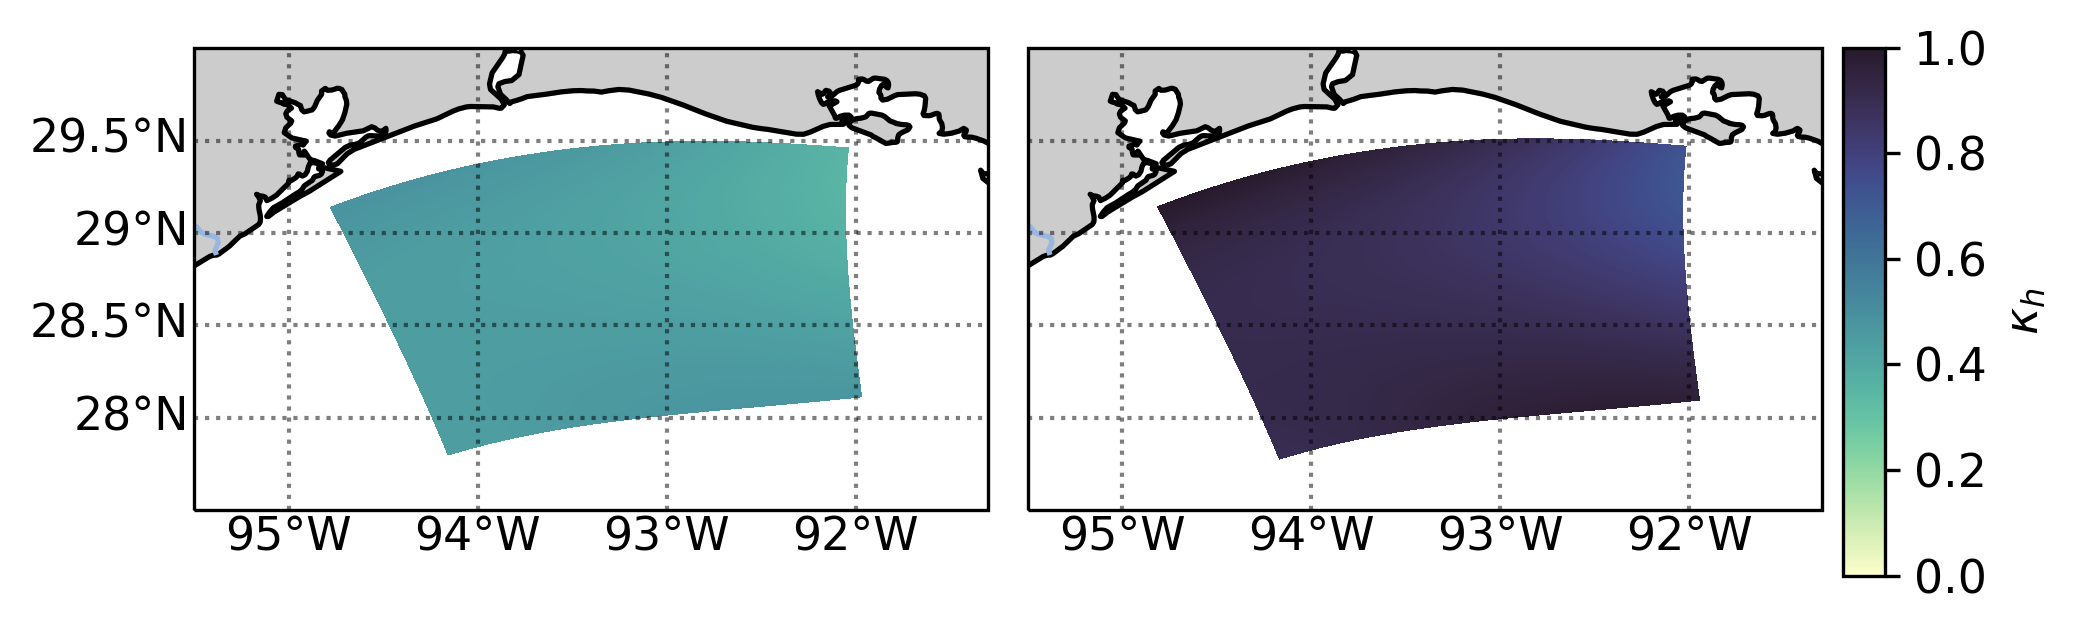

In [4]:
fig, ax = plt.subplots(1,2, figsize = (7,2), dpi = 300, subplot_kw={'projection': crs}, tight_layout = False)

ax[0].pcolormesh(ds_avg.lon_rho.isel(eta_rho=etaslice, xi_rho = xislice),
           ds_avg.lat_rho.isel(eta_rho=etaslice, xi_rho = xislice),
           kh_parent.isel(eta_rho=etaslice, xi_rho = xislice),
           vmin = 0, vmax = 1, cmap = cmo.deep, transform = ccrs.PlateCarree())
c1 = ax[1].pcolormesh(ds_avg_child.lon_rho,
           ds_avg_child.lat_rho,
           kh_child, 
           vmin = 0, vmax = 1, cmap = cmo.deep, transform = ccrs.PlateCarree())

for j in range(2):
    ax[j].set_extent([-95.5, -91.3, 27.5, 30], ccrs.PlateCarree())
    ax[j].add_feature(land_10m, facecolor='0.8', linewidth = 1.25)
    ax[j].coastlines(resolution='10m', linewidth = 1.25)  
    ax[j].add_feature(cfeature.BORDERS, linewidth=1.25)
    ax[j].add_feature(cartopy.feature.RIVERS, linewidth=1.25)
    ax[j].set_aspect('auto')

gl = ax[0].gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True
gl = ax[1].gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True
# fig.show()
cax = fig.add_axes([0.91, 0.001, 0.02, 0.88]) #this locates the axis that is used for your colorbar. It is scaled 0 - 1. 
fig.colorbar(c1, cax, orientation = 'vertical', label = '$\kappa_h$')
plt.subplots_adjust(wspace=0.05, hspace=0)
# cb = plt.colorbar(c1, ax = ax[1], ticks = [0, 0.25, 0.50, 0.75, 1.0], label = '$K_h$ [m$^2$ s$^{-1}$]')
fig.show()

In [88]:
timedrop = [np.datetime64('2010-06-18T18:30:00.000000000'), 
            np.datetime64('2010-06-19T18:30:00.000000000'), 
            np.datetime64('2010-07-09T18:30:00.000000000')]

ds_avg_child = ds_avg_child.where((ds_avg_child.ocean_time!= timedrop[0])
                           & (ds_avg_child.ocean_time!= timedrop[1])
                           & (ds_avg_child.ocean_time!= timedrop[2]),
                              drop=True)

ds_avg = ds_avg.where(ds_avg_child.ocean_time==ds_avg.ocean_time)

In [115]:
def chi_horz_hgrad(grid, ds, kh, etaslice, xislice):
    '''
Computes the horizontal component of salinity variance dissipation using the xroms hgrad 
Notes: chi_h = 2 * kappa_h * \nabla_H(s)^2
    '''
    dsaltdxi, dsaltdeta = xroms.hgrad(ds.salt, grid)
    dsdx_rho = grid.interp(xroms.to_rho(dsaltdxi, grid), 'Z')
    dsdy_rho = grid.interp(xroms.to_rho(dsaltdeta, grid), 'Z')

    chih = 2*kh*(dsdx_rho**2+dsdy_rho**2)

    return chih

chih = chi_horz_hgrad(grid_avg, ds_avg, kh_parent, etaslice, xislice)
chih_dz = (chih*ds_avg.dz).isel(eta_rho = etaslice, xi_rho = xislice).sum(['s_rho'])
chih_dz.attrs = ''

chih_child = chi_horz_hgrad(grid_avg_child, ds_avg_child, kh_child, etaslice_child, xislice_child)
chih_dz_child = (chih_child*ds_avg_child.dz).isel(eta_rho = etaslice_child, xi_rho = xislice_child).sum(['s_rho'])
chih_dz_child.attrs = ''

In [121]:
print('saving outputs')
dates = np.arange('2010-06-03', '2010-07-14', dtype = 'datetime64[D]') 
for d in range(len(dates)):    
    # chih_dz_sel = chih_dz.sel(ocean_time = str(dates[d]))
    # chih_dz_sel.name = 'chih_dz'
    # path = '/d2/home/dylan/JAMES/revised_submission/horz_terms/chi_horz_depth_integ/chih_dz_2010_srho_%s.nc' %d
    # chih_dz_sel.to_netcdf(path, mode = 'w')
    
    chih_dz_sel_child = chih_dz_child.sel(ocean_time = str(dates[d]))
    chih_dz_sel_child.name = 'chih_dz'
    path = '/d2/home/dylan/JAMES/revised_submission/horz_terms/chi_horz_depth_integ/chih_dz_2010_srho_child_%s.nc' %d
    chih_dz_sel_child.to_netcdf(path, mode = 'w')

saving outputs


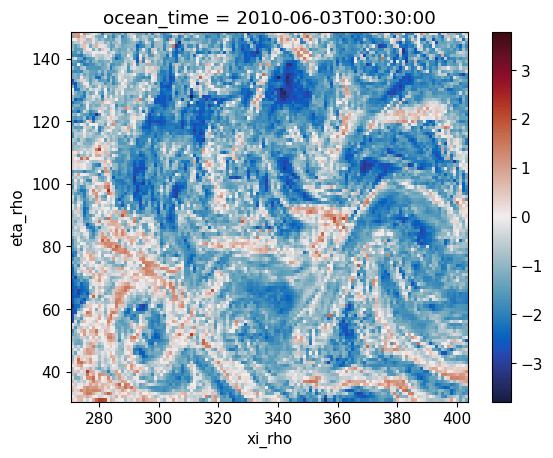

In [107]:
r1 = chih_dz.sel(ocean_time = '2010-06-03T00:30:00.000000000')/chi_dz[0]
np.log10(r1).plot(cmap = cmo.balance)

In [5]:
chi_dz = xr.open_mfdataset('/d2/home/dylan/JAMES/histogram_outputs/depth_int_mixing/chi_dz_2010_srho_*.nc').chi_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
chi_dz_child = xr.open_mfdataset('/d2/home/dylan/JAMES/histogram_outputs/depth_int_mixing/chi_dz_child_2010_*.nc').chi_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

chih_dz = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/chi_horz_depth_integ/chih_dz_2010_srho_*.nc').chih_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
chih_dz_child = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/t1/chih_dz_2010_srho_*.nc').chih_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

mnum_dz = xr.open_mfdataset('/d2/home/dylan/JAMES/histogram_outputs/depth_int_mixing/mnum_dz_2010_srho_*.nc').mnum_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
mnum_dz_child = xr.open_mfdataset('/d2/home/dylan/JAMES/histogram_outputs/depth_int_mixing/mnum_dz_child_2010_*.nc').mnum_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

#Time integrate
dt = 3600
chi_tint = (chi_dz.cumsum('ocean_time')*dt)#.load()
chi_tint_child = (chi_dz_child.cumsum('ocean_time')*dt)#.load()

chih_tint = (chih_dz.cumsum('ocean_time')*dt)#.load()
chih_tint_child = (chih_dz_child.cumsum('ocean_time')*dt)#.load()

mnum_tint = (mnum_dz.cumsum('ocean_time')*dt)#.load()
mnum_tint_child = (mnum_dz_child.cumsum('ocean_time')*dt)#.load()

r1 = chih_tint/chi_tint

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/tmp/ipykernel_8840/1882227940.py:95: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py

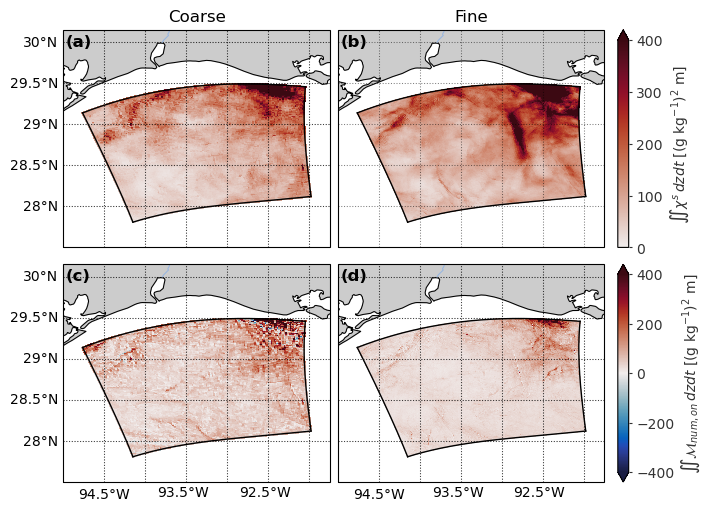

In [6]:
plt.rcParams.update({'font.size': 10})
crs = ccrs.PlateCarree(central_longitude=-93.5)
fig,ax = plt.subplots(2,2, figsize = (7,5), dpi = 100, subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                            ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                            chi_tint[-1], vmin = 0, vmax = 400,
                            cmap = cmo.amp,
                            transform = ccrs.PlateCarree())

mappable1 = ax[0,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                            ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                            chi_tint_child[-1], 
                            cmap = cmo.amp,vmin = 0, vmax = 400,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax[0,1], extend = 'max')
cb.set_label(r'$\iint \chi^s \, dzdt$ [(g kg$^{-1}$)$^2$ m]', color='0.2')
cb.ax.tick_params(length=2, color='0.2', labelcolor='0.2')

mappable = ax[1,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             mnum_tint[-1], vmin = -400, vmax = 400,
                             cmap = cmo.balance,
                             transform = ccrs.PlateCarree())

mappable1 = ax[1,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             mnum_tint_child[-1], 
                             cmap = cmo.balance, vmin = -400, vmax = 400,
                             transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax[1,1], extend = 'both', ticks = [-400, -200, 0, 200, 400],)
cb.set_label(r'$\iint \mathcal{M}_{num, on} \, dzdt$ [(g kg$^{-1}$)$^2$ m]', color='0.2')
cb.ax.tick_params(length=2, color='0.2',  labelcolor='0.2')

for i in range(2):
    for j in range(2):
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child)[-1,:], 
                     ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child)[-1,:], 'k', 
                                    lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[0,:], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[0,:], 
                                    'k', lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[:,0], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[:,0], 
                                    'k', lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[:,-1], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[:,-1], 'k', 
                                    lw=1,transform = ccrs.PlateCarree())

        ax[i,j].set_aspect('auto')
        ax[i,j].set_extent([-95, -91.75, 27.5, 30.15], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].coastlines(resolution='10m', linewidth = 0.75)  
        ax[i,j].add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.75)
        ax[i,j].add_feature(cfeature.RIVERS, linewidth=0.75)
        ax[i,j].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)

gl = ax[0,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True

gl = ax[1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True

gl = ax[1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False

ax[0,0].set_title('Coarse')
ax[0,1].set_title('Fine')

ax[0,0].annotate('(a)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[0,1].annotate('(b)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,0].annotate('(c)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,1].annotate('(d)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
fig.canvas.draw()

# plt.savefig('depth_integrated_mixing.jpg', dpi = 300, bbox_inches="tight")  

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically i

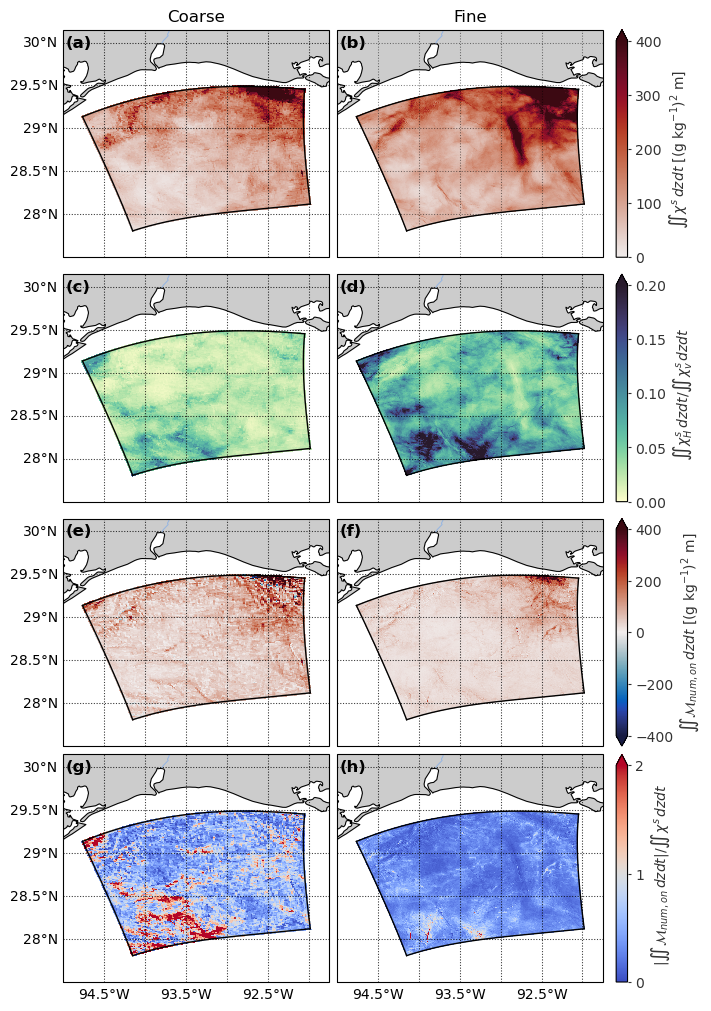

In [10]:
import matplotlib.ticker as tick

plt.rcParams.update({'font.size': 10})
crs = ccrs.PlateCarree(central_longitude=-93.5)
fig,ax = plt.subplots(4,2, figsize = (7,10), subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                            ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                            chi_tint[-1]+chih_tint.isel(ocean_time=-1), vmin = 0, vmax = 400,
                            cmap = cmo.amp,
                            transform = ccrs.PlateCarree())

mappable1 = ax[0,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                            ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                            chi_tint_child[-1]+chih_tint_child.isel(ocean_time=-1), 
                            cmap = cmo.amp,vmin = 0, vmax = 400,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax[0,1], extend = 'max')
cb.set_label(r'$\iint \chi^s \, dzdt$ [(g kg$^{-1}$)$^2$ m]', color='0.2')
cb.ax.tick_params(length=2, color='0.2', labelcolor='0.2')

mappable = ax[1,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                              ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             ((chih_tint.isel(ocean_time=-1))/chi_tint[-1]), vmin = 0, vmax = 0.20,
                              cmap = cmo.deep,
                              transform = ccrs.PlateCarree())

mappable = ax[1,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                              ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             ((chih_tint_child.isel(ocean_time=-1))/chi_tint_child.isel(ocean_time=-1)), vmin = 0, vmax = 0.20,
                              cmap = cmo.deep,
                              transform = ccrs.PlateCarree(), )

cb = fig.colorbar(mappable, ax = ax[1,1], extend = 'max', ticks = [0, 0.05, 0.1, 0.15, 0.2]) #, format=tick.FormatStrFormatter('$10^{%d}$')
cb.set_label(r'$\iint \chi_H^s \, dzdt/ \iint \chi_v^s \, dzdt$', color='0.2')
cb.ax.tick_params(length=2, color='0.2',  labelcolor='0.2')

mappable = ax[2,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             mnum_tint[-1], vmin = -400, vmax = 400,
                             cmap = cmo.balance,
                             transform = ccrs.PlateCarree())

mappable1 = ax[2,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             mnum_tint_child[-1], 
                             cmap = cmo.balance, vmin = -400, vmax = 400,
                             transform = ccrs.PlateCarree())


cb = fig.colorbar(mappable, ax = ax[2,1], extend = 'both', ticks = [-400, -200, 0, 200, 400],)
cb.set_label(r'$\iint \mathcal{M}_{num, on} \, dzdt$ [(g kg$^{-1}$)$^2$ m]', color='0.2')
cb.ax.tick_params(length=2, color='0.2',  labelcolor='0.2')

mappable = ax[3,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                              ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             (np.abs(mnum_tint[-1])/chi_tint[-1]), vmin = 0, vmax = 2,
                              cmap = plt.get_cmap('coolwarm'),
                              transform = ccrs.PlateCarree())

mappable = ax[3,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                              ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             (np.abs(mnum_tint_child[-1])/chi_tint_child[-1]), vmin = 0, vmax = 2,
                              cmap = plt.get_cmap('coolwarm'),
                              transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax[3,1], extend = 'max', ticks = [0, 1, 2],)
cb.set_label(r'$|\iint \mathcal{M}_{num, on} \, dzdt|/\iint \chi^s \, dzdt$', color='0.2')
cb.ax.tick_params(length=2, color='0.2',  labelcolor='0.2')

for i in range(4):
    for j in range(2):
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child)[-1,:], 
                     ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child)[-1,:], 'k', 
                                    lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[0,:], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[0,:], 
                                    'k', lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[:,0], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[:,0], 
                                    'k', lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[:,-1], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[:,-1], 'k', 
                                    lw=1,transform = ccrs.PlateCarree())

        ax[i,j].set_aspect('auto')
        ax[i,j].set_extent([-95, -91.75, 27.5, 30.15], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].coastlines(resolution='10m', linewidth = 0.75)  
        ax[i,j].add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.75)
        ax[i,j].add_feature(cfeature.RIVERS, linewidth=0.75)
        ax[i,j].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)

gl = ax[0,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True

gl = ax[1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True

gl = ax[1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False 
gl.left_labels = False

gl = ax[2,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True

gl = ax[2,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)

gl = ax[3,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True 
gl.left_labels = True

gl = ax[3,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False

ax[0,0].set_title('Coarse')
ax[0,1].set_title('Fine')

ax[0,0].annotate('(a)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[0,1].annotate('(b)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,0].annotate('(c)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,1].annotate('(d)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[2,0].annotate('(e)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[2,1].annotate('(f)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[3,0].annotate('(g)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[3,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[3,1].annotate('(h)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[3,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
fig.canvas.draw()

plt.savefig('dzdt_int_mixing.jpg', dpi = 300, bbox_inches="tight")  

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically i

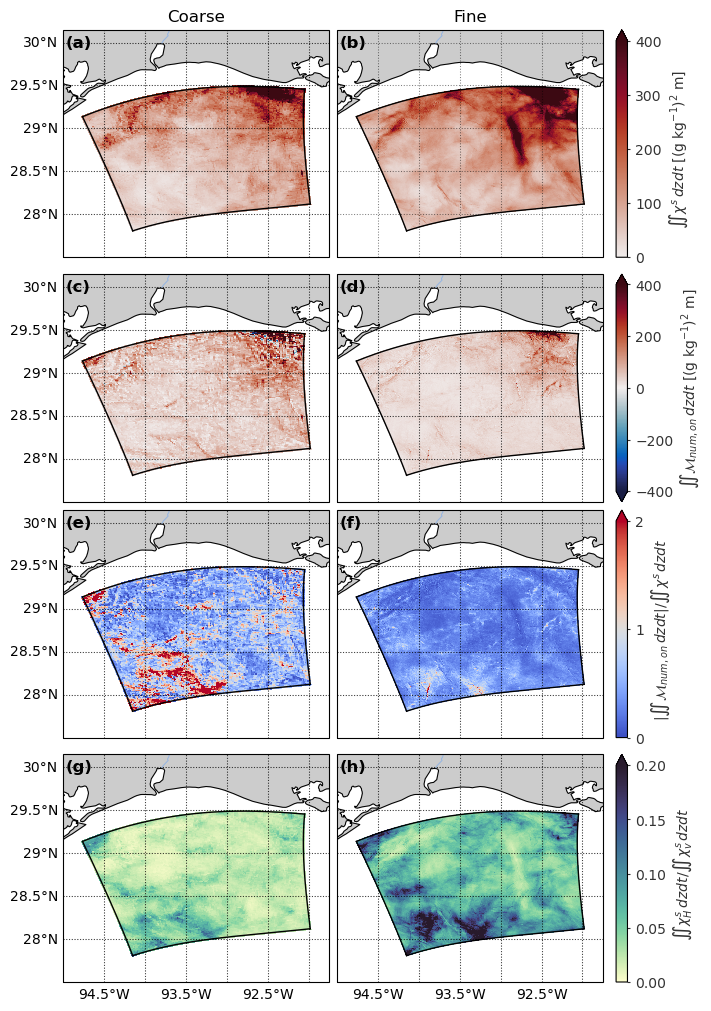

In [7]:
import matplotlib.ticker as tick

plt.rcParams.update({'font.size': 10})
crs = ccrs.PlateCarree(central_longitude=-93.5)
fig,ax = plt.subplots(4,2, figsize = (7,10), subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                            ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                            chi_tint[-1], vmin = 0, vmax = 400,
                            cmap = cmo.amp,
                            transform = ccrs.PlateCarree())

mappable1 = ax[0,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                            ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                            chi_tint_child[-1], 
                            cmap = cmo.amp,vmin = 0, vmax = 400,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax[0,1], extend = 'max')
cb.set_label(r'$\iint \chi^s \, dzdt$ [(g kg$^{-1}$)$^2$ m]', color='0.2')
cb.ax.tick_params(length=2, color='0.2', labelcolor='0.2')

mappable = ax[1,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             mnum_tint[-1], vmin = -400, vmax = 400,
                             cmap = cmo.balance,
                             transform = ccrs.PlateCarree())

mappable1 = ax[1,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             mnum_tint_child[-1], 
                             cmap = cmo.balance, vmin = -400, vmax = 400,
                             transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax[1,1], extend = 'both', ticks = [-400, -200, 0, 200, 400],)
cb.set_label(r'$\iint \mathcal{M}_{num, on} \, dzdt$ [(g kg$^{-1}$)$^2$ m]', color='0.2')
cb.ax.tick_params(length=2, color='0.2',  labelcolor='0.2')

mappable = ax[2,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                              ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             (np.abs(mnum_tint[-1])/chi_tint[-1]), vmin = 0, vmax = 2,
                              cmap = plt.get_cmap('coolwarm'),
                              transform = ccrs.PlateCarree())

mappable = ax[2,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                              ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             (np.abs(mnum_tint_child[-1])/chi_tint_child[-1]), vmin = 0, vmax = 2,
                              cmap = plt.get_cmap('coolwarm'),
                              transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax[2,1], extend = 'max', ticks = [0, 1, 2],)
cb.set_label(r'$|\iint \mathcal{M}_{num, on} \, dzdt|/\iint \chi^s \, dzdt$', color='0.2')
cb.ax.tick_params(length=2, color='0.2',  labelcolor='0.2')

mappable = ax[3,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                              ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             ((chih_tint.isel(ocean_time=-1))/chi_tint[-1]), vmin = 0, vmax = 0.20,
                              cmap = cmo.deep,
                              transform = ccrs.PlateCarree())

mappable = ax[3,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                              ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             ((chih_tint_child.isel(ocean_time=-1))/chi_tint_child.isel(ocean_time=-1)), vmin = 0, vmax = 0.20,
                              cmap = cmo.deep,
                              transform = ccrs.PlateCarree(), )

cb = fig.colorbar(mappable, ax = ax[3,1], extend = 'max', ticks = [0, 0.05, 0.1, 0.15, 0.2]) #, format=tick.FormatStrFormatter('$10^{%d}$')
cb.set_label(r'$\iint \chi_H^s \, dzdt/ \iint \chi_v^s \, dzdt$', color='0.2')
cb.ax.tick_params(length=2, color='0.2',  labelcolor='0.2')

for i in range(4):
    for j in range(2):
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child)[-1,:], 
                     ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child)[-1,:], 'k', 
                                    lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[0,:], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[0,:], 
                                    'k', lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[:,0], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[:,0], 
                                    'k', lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[:,-1], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[:,-1], 'k', 
                                    lw=1,transform = ccrs.PlateCarree())

        ax[i,j].set_aspect('auto')
        ax[i,j].set_extent([-95, -91.75, 27.5, 30.15], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].coastlines(resolution='10m', linewidth = 0.75)  
        ax[i,j].add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.75)
        ax[i,j].add_feature(cfeature.RIVERS, linewidth=0.75)
        ax[i,j].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)

gl = ax[0,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True

gl = ax[1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True

gl = ax[1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False 
gl.left_labels = False

gl = ax[2,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True

gl = ax[2,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)

gl = ax[3,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True 
gl.left_labels = True

gl = ax[3,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False

ax[0,0].set_title('Coarse')
ax[0,1].set_title('Fine')

ax[0,0].annotate('(a)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[0,1].annotate('(b)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,0].annotate('(c)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,1].annotate('(d)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[2,0].annotate('(e)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[2,1].annotate('(f)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[3,0].annotate('(g)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[3,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[3,1].annotate('(h)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[3,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
fig.canvas.draw()

# plt.savefig('dzdt_int_mixing.jpg', dpi = 300, bbox_inches="tight")  